# MDP Hyperbolic Embeddings

This notebook explores hyperbolic embeddings for (state, goal) pairs in a 6-state MDP.

## MDP Structure

```
State 1 (start)
    |
    |-- a11 (stochastic) --> 4 (p=0.5) or 5 (p=0.5) --> 6 (goal)
    |
    |-- a12 (deterministic) --> 2 --> (0.9 self-loop, 0.1 to 4) --> 6
    |
    |-- a13 (deterministic) --> 3 --> (0.9 self-loop, 0.1 to 5) --> 6
```

In [1]:
!pip install hypll geoopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from scipy import stats

# Import hypll library
from hypll.manifolds.poincare_ball import PoincareBall, Curvature
from hypll.tensors.manifold_tensor import ManifoldTensor
from hypll.tensors import TangentTensor
import hypll.nn as hnn

# Setup
sns.set_style("whitegrid")
np.random.seed(42)
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## MDP Definition

In [67]:
class SimpleMDP:
    """
    6-state MDP with the following structure:

    States (0-indexed internally, displayed as 1-6):
        0 (State 1): Start state, 3 actions available
        1 (State 2): Self-loop (0.9) or to state 3 (0.1)
        2 (State 3): Self-loop (0.9) or to state 4 (0.1)
        3 (State 4): Deterministic to goal (state 5)
        4 (State 5): Deterministic to goal (state 5)
        5 (State 6): Goal (terminal)

    From state 0:
        - a0: Stochastic -> state 3 (p=0.5) or state 4 (p=0.5)
        - a1: Deterministic -> state 1
        - a2: Deterministic -> state 2
    """

    def __init__(self):
        self.n_states = 6
        self.start_state = 0  # State 1
        self.goal_state = 5   # State 6

        # Number of actions per state
        self.n_actions = {
            0: 3,  # State 1: a11, a12, a13
            1: 1,  # State 2: only one action (stochastic outcome)
            2: 1,  # State 3: only one action (stochastic outcome)
            3: 1,  # State 4: deterministic to goal
            4: 1,  # State 5: deterministic to goal
            5: 0,  # State 6: terminal
        }

    def get_transitions(self, state, action):
        """
        Get transition probabilities for (state, action) pair.
        Returns list of (next_state, probability) tuples.
        """
        if state == 0:  # State 1 (start)
            if action == 0:  # a11: stochastic
                return [(3, 0.5), (4, 0.5)]  # -> State 4 or 5
            elif action == 1:  # a12: deterministic
                return [(1, 1.0)]  # -> State 2
            elif action == 2:  # a13: deterministic
                return [(2, 1.0)]  # -> State 3

        elif state == 1:  # State 2
            return [(1, 0.9), (3, 0.1)]  # Self-loop or -> State 4

        elif state == 2:  # State 3
            return [(2, 0.9), (4, 0.1)]  # Self-loop or -> State 5

        elif state == 3:  # State 4
            return [(5, 1.0)]  # -> Goal (State 6)

        elif state == 4:  # State 5
            return [(5, 1.0)]  # -> Goal (State 6)

        elif state == 5:  # State 6 (goal)
            return [(5, 1.0)]  # Stay at goal

        return []

    def step(self, state, action=None):
        """
        Take a step from state with given action.
        If action is None, sample uniformly from available actions.
        Returns next_state.
        """
        if state == self.goal_state:
            return state

        if action is None:
            n_actions = self.n_actions[state]
            action = np.random.randint(0, max(1, n_actions))

        transitions = self.get_transitions(state, action)

        if len(transitions) == 1:
            return transitions[0][0]

        # Sample according to probabilities
        probs = [t[1] for t in transitions]
        next_states = [t[0] for t in transitions]
        return np.random.choice(next_states, p=probs)

    def state_name(self, state):
        """Return human-readable state name."""
        return f"{state + 1}"

    def get_all_reachable_pairs(self):
      """
      Outputs all state pairs (s,g) that satisfy either s=g,
      or it is possible to go from s to g.
      """
      pairs = []
      for s in range(self.n_states):
          # BFS to find reachable states from s
          visited = {s}
          queue = [s]

          while queue:
              curr = queue.pop(0)

              # Iterate over all available actions from current state
              n_act = self.n_actions.get(curr, 0)
              for action in range(n_act):
                  transitions = self.get_transitions(curr, action)
                  for next_state, prob in transitions:
                      if prob > 0 and next_state not in visited:
                          visited.add(next_state)
                          queue.append(next_state)

          # Add all pairs (s, reachable_node)
          for g in visited:
              pairs.append((s, g))

      return sorted(pairs)

    def get_all_neighbors(self):
      """
      Outputs all state pairs (s,g) that satisfy either s=g or it is possible to go from s to g in one step.
      """
      neighbors = []
      for s in range(self.n_states):
          n_act = self.n_actions.get(s, 0)
          neighbors.append((s,s))
          for action in range(n_act):
              transitions = self.get_transitions(s, action)
              for next_state, prob in transitions :
                  if prob > 0 and next_state != s:
                      neighbors.append((s, next_state))

      return neighbors





# Test the MDP
mdp = SimpleMDP()
print("MDP Structure Test:")
print(f"Start state: {mdp.state_name(mdp.start_state)}")
print(f"Goal state: {mdp.state_name(mdp.goal_state)}")
print([(mdp.state_name(pair[0]), mdp.state_name(pair[1]))for pair in mdp.get_all_reachable_pairs()])
print([(mdp.state_name(pair[0]), mdp.state_name(pair[1]))for pair in mdp.get_all_neighbors()])
print()
for state in range(mdp.n_states):
    print(f"{mdp.state_name(state)}: {mdp.n_actions[state]} actions")
    for action in range(mdp.n_actions[state]):
        transitions = mdp.get_transitions(state, action)
        trans_str = ", ".join([f"{mdp.state_name(s)} (p={p})" for s, p in transitions])
        print(f"  a{action}: {trans_str}")



MDP Structure Test:
Start state: 1
Goal state: 6
[('1', '1'), ('1', '2'), ('1', '3'), ('1', '4'), ('1', '5'), ('1', '6'), ('2', '2'), ('2', '4'), ('2', '6'), ('3', '3'), ('3', '5'), ('3', '6'), ('4', '4'), ('4', '6'), ('5', '5'), ('5', '6'), ('6', '6')]
[('1', '1'), ('1', '4'), ('1', '5'), ('1', '2'), ('1', '3'), ('2', '2'), ('2', '4'), ('3', '3'), ('3', '5'), ('4', '4'), ('4', '6'), ('5', '5'), ('5', '6'), ('6', '6')]

1: 3 actions
  a0: 4 (p=0.5), 5 (p=0.5)
  a1: 2 (p=1.0)
  a2: 3 (p=1.0)
2: 1 actions
  a0: 2 (p=0.9), 4 (p=0.1)
3: 1 actions
  a0: 3 (p=0.9), 5 (p=0.1)
4: 1 actions
  a0: 6 (p=1.0)
5: 1 actions
  a0: 6 (p=1.0)
6: 0 actions


## Trajectory Generation

In [6]:
def generate_mdp_trajectories(mdp, n_trajectories, max_length=1000, seed=42):
    """
    Generate trajectories from start to goal under uniform random policy.

    Args:
        mdp: SimpleMDP instance
        n_trajectories: Number of trajectories to generate
        max_length: Maximum trajectory length
        seed: Random seed

    Returns:
        List of state sequences (lists of state indices)
    """
    np.random.seed(seed)
    trajectories = []

    for _ in range(n_trajectories):
        traj = [mdp.start_state]
        state = mdp.start_state

        for _ in range(max_length):
            if state == mdp.goal_state:
                break

            # Uniform random action selection
            state = mdp.step(state, action=None)
            traj.append(state)

        trajectories.append(traj)

    return trajectories


# Generate trajectories
trajectories = generate_mdp_trajectories(mdp, n_trajectories=5000, max_length=1000, seed=42)

# Analyze trajectories
lengths = [len(t) for t in trajectories]
print(f"Generated {len(trajectories)} trajectories")
print(f"Length stats: mean={np.mean(lengths):.1f}, std={np.std(lengths):.1f}, min={min(lengths)}, max={max(lengths)}")

# Show sample trajectories
print("\nSample trajectories:")
for i in range(5):
    traj_str = " -> ".join([mdp.state_name(s) for s in trajectories[i][:15]])
    if len(trajectories[i]) > 15:
        traj_str += f" ... ({len(trajectories[i])} states total)"
    print(f"  {i+1}: {traj_str}")

Generated 5000 trajectories
Length stats: mean=9.7, std=9.2, min=3, max=84

Sample trajectories:
  1: S1 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S3 -> S5 ... (16 states total)
  2: S1 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 ... (23 states total)
  3: S1 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S4 -> S6
  4: S1 -> S2 -> S2 -> S2 -> S2 -> S2 -> S2 -> S4 -> S6
  5: S1 -> S2 -> S2 -> S2 -> S4 -> S6


## Contrastive Dataset

In [7]:
class MDPContrastiveDataset(Dataset):
    """
    Dataset for contrastive learning on MDP trajectory intervals.

    For each sample:
    - Anchor: [start_state, goal_state] interval from trajectory
    - Positive: Subinterval [k, l] where anchor_i <= k <= l <= anchor_j
    - Negatives: Intervals that are NOT subintervals of anchor

    States are normalized to [0, 1] by dividing by (n_states - 1).
    """

    def __init__(self, trajectories, n_states=6, num_samples=10000, n_negatives=5, seed=42):
        self.trajectories = trajectories
        self.n_states = n_states
        self.num_samples = num_samples
        self.n_negatives = n_negatives

        np.random.seed(seed)
        torch.manual_seed(seed)

        # Filter valid trajectories (need at least 2 states for intervals)
        self.valid_traj_indices = [i for i, t in enumerate(trajectories) if len(t) >= 2]

        # Pre-generate all samples
        self.anchors, self.positives, self.negatives = self._generate_all_samples()

    def _normalize_state(self, state):
        """Normalize state index to [0, 1]."""
        return state / (self.n_states - 1)

    def _generate_all_samples(self):
        anchors = []
        positives = []
        negatives_list = []

        for _ in range(self.num_samples):
            anchor, positive, negs = self._generate_single_sample()
            anchors.append(anchor)
            positives.append(positive)
            negatives_list.append(negs)

        return (
            torch.tensor(anchors, dtype=torch.float32),
            torch.tensor(positives, dtype=torch.float32),
            torch.tensor(negatives_list, dtype=torch.float32),
        )

    def _generate_single_sample(self):
        """Generate a single (anchor, positive, negatives) tuple."""
        # Sample trajectory
        traj_idx = np.random.choice(self.valid_traj_indices)
        traj = self.trajectories[traj_idx]
        T = len(traj) - 1

        # Sample anchor interval [i, j] where i <= j
        j = np.random.randint(0, T + 1)
        i = np.random.randint(0, j + 1)

        anchor = [self._normalize_state(traj[i]), self._normalize_state(traj[j])]

        # Sample positive (subinterval): i <= k <= l <= j
        l = np.random.randint(i, j + 1)
        k = np.random.randint(i, l + 1)

        positive = [self._normalize_state(traj[k]), self._normalize_state(traj[l])]

        # Sample negatives (non-subintervals)
        negatives = []
        for _ in range(self.n_negatives):
            neg = self._sample_negative(traj, i, j, T)
            negatives.append(neg)

        return anchor, positive, negatives

    def _sample_negative(self, traj, anchor_i, anchor_j, T, max_attempts=1000):
        """Sample an interval that is NOT a subinterval of anchor."""
        for _ in range(max_attempts):
            l = np.random.randint(0, T + 1)
            k = np.random.randint(0, l + 1)

            # Check if NOT a subinterval (temporal containment)
            is_subinterval = (anchor_i <= k) and (l <= anchor_j)

            if not is_subinterval:
                return [self._normalize_state(traj[k]), self._normalize_state(traj[l])]

        # Fallback
        if anchor_i > 0:
            return [self._normalize_state(traj[0]), self._normalize_state(traj[0])]
        else:
            return [self._normalize_state(traj[T]), self._normalize_state(traj[T])]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.anchors[idx], self.positives[idx], self.negatives[idx]


# Create dataset
dataset = MDPContrastiveDataset(
    trajectories=trajectories,
    n_states=6,
    num_samples=10000,
    n_negatives=5,
    seed=42
)

# Check shapes
anchor, positive, negatives = dataset[0]
print(f"Anchor shape: {anchor.shape}")
print(f"Positive shape: {positive.shape}")
print(f"Negatives shape: {negatives.shape}")
print(f"\nSample anchor: {anchor}")
print(f"Sample positive: {positive}")
print(f"Sample negatives[0]: {negatives[0]}")

Anchor shape: torch.Size([2])
Positive shape: torch.Size([2])
Negatives shape: torch.Size([5, 2])

Sample anchor: tensor([1., 1.])
Sample positive: tensor([1., 1.])
Sample negatives[0]: tensor([0., 0.])


## Hyperbolic Encoder

In [8]:
def manifold_map(x, manifold):
    """Map Euclidean tensor to hyperbolic manifold via exponential map."""
    tangents = TangentTensor(x, man_dim=-1, manifold=manifold)
    return manifold.expmap(tangents)


class HyperbolicIntervalEncoder(nn.Module):
    """
    Encode (state, goal) pairs to Poincare ball.
    Architecture: 2 Euclidean layers + 2 Hyperbolic layers
    """

    def __init__(self, embedding_dim=2, c=1.0, euc_width=128, hyp_width=128):
        super().__init__()

        # Create manifold
        curvature = Curvature(value=c, requires_grad=False)
        self.manifold = PoincareBall(c=curvature)

        # Euclidean layers
        self.euc_layer1 = nn.Linear(2, euc_width)
        self.euc_layer2 = nn.Linear(euc_width, hyp_width)
        self.euc_relu = nn.ReLU()

        # Hyperbolic layers
        self.hyp_layer1 = hnn.HLinear(
            in_features=hyp_width,
            out_features=hyp_width,
            manifold=self.manifold
        )
        self.hyp_layer2 = hnn.HLinear(
            in_features=hyp_width,
            out_features=embedding_dim,
            manifold=self.manifold
        )
        self.hyp_relu = hnn.HReLU(manifold=self.manifold)

    def forward(self, x):
        # Euclidean part
        x = self.euc_relu(self.euc_layer1(x))
        x = self.euc_layer2(x)

        # Map to hyperbolic space
        x = manifold_map(x, self.manifold)

        # Hyperbolic part
        x = self.hyp_relu(self.hyp_layer1(x))
        x = self.hyp_layer2(x)

        return x


# Test encoder
model = HyperbolicIntervalEncoder(embedding_dim=2, c=1.0).to(device)
test_input = torch.tensor([[0.0, 1.0], [0.2, 0.8]], dtype=torch.float32).to(device)
test_output = model(test_input)
print(f"Test input shape: {test_input.shape}")
print(f"Test output type: {type(test_output)}")
if isinstance(test_output, ManifoldTensor):
    print(f"Test output tensor shape: {test_output.tensor.shape}")
    print(f"Test output: {test_output.tensor}")

Test input shape: torch.Size([2, 2])
Test output type: <class 'hypll.tensors.manifold_tensor.ManifoldTensor'>
Test output tensor shape: torch.Size([2, 2])
Test output: tensor([[-0.4113, -0.3351],
        [-0.3118, -0.3144]], grad_fn=<WhereBackward0>)


## Loss Function

In [9]:
def info_nce_loss(anchor, positive, negatives, manifold, temperature=0.5):
    """InfoNCE loss using hyperbolic distance."""
    batch_size = anchor.shape[0] if not isinstance(anchor, ManifoldTensor) else anchor.tensor.shape[0]
    num_neg = negatives.shape[1] if not isinstance(negatives, ManifoldTensor) else negatives.tensor.shape[1]

    # Compute positive distance
    pos_dist = manifold.dist(x=anchor, y=positive)

    # Expand anchor for negative comparisons
    if isinstance(anchor, ManifoldTensor):
        anchor_tensor = anchor.tensor.unsqueeze(1).expand(-1, num_neg, -1)
        anchor_expanded = ManifoldTensor(anchor_tensor, manifold=manifold)
    else:
        anchor_expanded = anchor.unsqueeze(1).expand(-1, num_neg, -1)

    neg_dist = manifold.dist(x=anchor_expanded, y=negatives)

    # Extract tensors
    if isinstance(pos_dist, ManifoldTensor):
        pos_dist = pos_dist.tensor
    if isinstance(neg_dist, ManifoldTensor):
        neg_dist = neg_dist.tensor

    # Reshape
    if pos_dist.dim() > 1:
        pos_dist = pos_dist.squeeze(-1)
    if neg_dist.dim() > 2:
        neg_dist = neg_dist.squeeze(-1)

    # Check for NaN
    if torch.isnan(pos_dist).any() or torch.isnan(neg_dist).any():
        print("WARNING: NaN in distances")
        return torch.tensor(0.0, device=pos_dist.device, requires_grad=True)

    # Convert distances to similarities
    pos_sim = -pos_dist / temperature
    neg_sim = -neg_dist / temperature

    # Combine for cross-entropy
    logits = torch.cat([pos_sim.unsqueeze(1), neg_sim], dim=1)
    labels = torch.zeros(batch_size, dtype=torch.long, device=logits.device)

    loss = nn.functional.cross_entropy(logits, labels)
    return loss

## Training

In [10]:
def train_model(model, dataset, num_epochs=200, batch_size=32, lr=0.001, temperature=0.1):
    """Train the hyperbolic encoder."""
    from hypll.optim import RiemannianAdam

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    losses = []
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for anchor, positive, negatives in dataloader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negatives = negatives.to(device)

            # Forward pass
            anchor_emb = model(anchor)
            positive_emb = model(positive)

            bs, num_neg, _ = negatives.shape
            negatives_emb = model(negatives.view(-1, 2))

            # Reshape negatives
            if isinstance(negatives_emb, ManifoldTensor):
                neg_tensor = negatives_emb.tensor.view(bs, num_neg, -1)
                negatives_emb = ManifoldTensor(neg_tensor, manifold=model.manifold)
            else:
                negatives_emb = negatives_emb.view(bs, num_neg, -1)

            # Loss
            loss = info_nce_loss(anchor_emb, positive_emb, negatives_emb,
                                model.manifold, temperature=temperature)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Skipping batch due to NaN/Inf loss")
                continue

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)
            scheduler.step()

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return losses

Epoch 20/50, Loss: 0.6669
Epoch 40/50, Loss: 0.6557


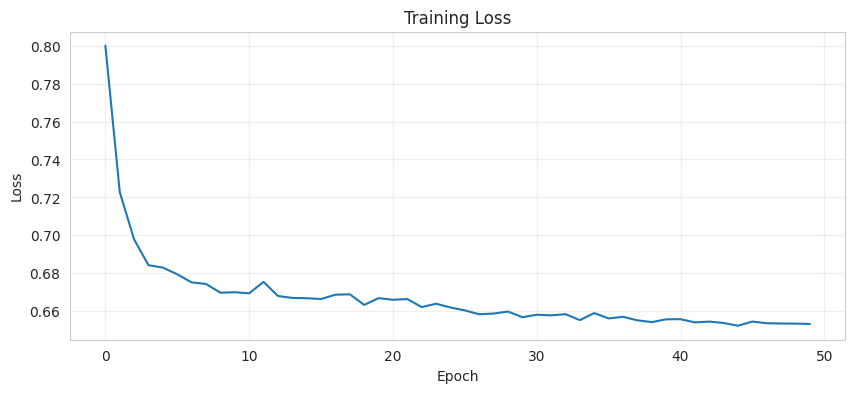

In [49]:
# Train the model
model = HyperbolicIntervalEncoder(embedding_dim=2, c=1.0, euc_width=128, hyp_width=128).to(device)
losses = train_model(model, dataset, num_epochs=50, batch_size=32, lr=0.001, temperature=0.5)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## Hitting Time Analysis

In [32]:
def compute_hitting_times(mdp, start_state, goal_state=5, n_simulations=10000, max_steps=10000):
    """
    Monte Carlo estimation of hitting times from start_state to goal_state
    under uniform random policy.

    Returns (mean, variance, std) of hitting times.
    """
    hitting_times = []

    for _ in range(n_simulations):
        state = start_state
        steps = 0

        while state != goal_state and steps < max_steps:
            state = mdp.step(state, action=None)
            steps += 1

        if state == goal_state:
            hitting_times.append(steps)

    if len(hitting_times) == 0:
        return float('inf'), float('inf'), float('inf')

    return np.mean(hitting_times), np.var(hitting_times), np.std(hitting_times)


def compute_all_hitting_times(mdp, n_simulations=1000):
    """
    Compute hitting time statistics for all (start, goal) pairs.

    Returns dict: {start_state: {'mean': ..., 'var': ..., 'std': ...}}
    """
    hitting_stats = {}
    goal = mdp.goal_state

    for pair in mdp.get_all_reachable_pairs():
        start, goal = pair
        mean, var, std = compute_hitting_times(mdp, start, goal, n_simulations)
        hitting_stats[pair] = {'mean': mean, 'var': var, 'std': std}
        print(f"{mdp.state_name(start)} -> {mdp.state_name(goal)}: mean={mean:.2f}, var={var:.2f}, std={std:.2f}")

    return hitting_stats


# Compute hitting times
print("Computing hitting time statistics...")
print("="*60)
hitting_stats = compute_all_hitting_times(mdp, n_simulations=1000)

Computing hitting time statistics...
1 -> 1: mean=0.00, var=0.00, std=0.00
1 -> 2: mean=1.00, var=0.00, std=0.00
1 -> 3: mean=1.00, var=0.00, std=0.00
1 -> 4: mean=7.77, var=90.79, std=9.53
1 -> 5: mean=7.49, var=76.31, std=8.74
1 -> 6: mean=9.13, var=94.51, std=9.72
2 -> 2: mean=0.00, var=0.00, std=0.00
2 -> 4: mean=9.63, var=80.84, std=8.99
2 -> 6: mean=11.14, var=100.66, std=10.03
3 -> 3: mean=0.00, var=0.00, std=0.00
3 -> 5: mean=10.14, var=96.99, std=9.85
3 -> 6: mean=11.21, var=88.32, std=9.40
4 -> 4: mean=0.00, var=0.00, std=0.00
4 -> 6: mean=1.00, var=0.00, std=0.00
5 -> 5: mean=0.00, var=0.00, std=0.00
5 -> 6: mean=1.00, var=0.00, std=0.00
6 -> 6: mean=0.00, var=0.00, std=0.00


## Visualization on Poincare Ball

In [50]:
# =============================================================================
# Utility Functions
# =============================================================================

def pair_label(start, goal):
    """
    Create label for (start, goal) pair.
    - Atomic pairs (s, s) displayed as just the number: "3"
    - Non-atomic pairs displayed as: "(1,6)"
    """
    # Convert from 0-indexed to 1-indexed for display
    s, g = start + 1, goal + 1
    if start == goal:
        return f"{s}"
    return f"({s},{g})"


def plot_poincare_disk(ax, title=""):
    """Draw Poincare disk boundary and origin."""
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2, linestyle='--')
    ax.add_patch(circle)
    ax.scatter([0], [0], s=60, c='black', marker='+', linewidth=2, zorder=10)
    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)
    if title:
        ax.set_title(title, fontsize=13)


def hyperbolic_norm(z, curvature=1.0):
    """Compute hyperbolic distance from origin to point z."""
    K = curvature
    z_norm = np.linalg.norm(z)
    z_norm = np.clip(z_norm, 0, (1 / np.sqrt(K)) - 1e-10)
    return (2 / np.sqrt(K)) * np.arctanh(np.sqrt(K) * z_norm)


def get_embedding(model, start, goal, n_states=6):
    """
    Get the embedding for a specific (start, goal) pair.

    Args:
        model: Trained HyperbolicIntervalEncoder
        start: Start state (0-indexed)
        goal: Goal state (0-indexed)
        n_states: Total number of states

    Returns:
        numpy array of shape (2,) - the embedding coordinates
    """
    model.eval()
    with torch.no_grad():
        s_norm = start / (n_states - 1)
        g_norm = goal / (n_states - 1)
        x = torch.tensor([[s_norm, g_norm]], dtype=torch.float32).to(device)
        emb = model(x)
        if isinstance(emb, ManifoldTensor):
            emb = emb.tensor
        return emb.squeeze(0).cpu().numpy()


def get_all_embeddings(model, n_states=6, include_atomic=True):
    """
    Get embeddings for all (state, goal) pairs.

    Args:
        model: Trained HyperbolicIntervalEncoder
        n_states: Total number of states
        include_atomic: Whether to include atomic (s, s) pairs

    Returns:
        Dict mapping (start, goal) -> embedding array
    """
    model.eval()
    embeddings = {}

    with torch.no_grad():
        for start in range(n_states):
            for goal in range(n_states):
                if include_atomic or start != goal:
                    emb = get_embedding(model, start, goal, n_states)
                    embeddings[(start, goal)] = emb

    return embeddings


def get_all_meaningful_embeddings(model, mdp):
    """
    Get embeddings for all (state, final_goal) pairs.
    This is for backwards compatibility.

    Returns dict: {start_state: embedding_array}
    """
    model.eval()
    embeddings = {}
    n_states = mdp.n_states

    with torch.no_grad():
        for pair in mdp.get_all_reachable_pairs():
            emb = get_embedding(model, pair[0], pair[1], n_states)
            embeddings[pair] = emb

    return embeddings


# Get embeddings for all (state, goal=6) pairs
embeddings = get_all_meaningful_embeddings(model, mdp)

# Print embeddings
print("State embeddings (state -> goal=6):")
for pair, emb in embeddings.items():
    norm = hyperbolic_norm(emb)
    angle = np.degrees(np.arctan2(emb[1], emb[0]))
    label = pair_label(*pair)
    print(f"  {label}: ({emb[0]:.4f}, {emb[1]:.4f}), norm={norm:.4f}, angle={angle:.1f}deg")

State embeddings (state -> goal=6):
  1: (0.8129, 0.0661), norm=2.2871, angle=4.7deg
  (1,2): (0.7597, 0.0745), norm=2.0084, angle=5.6deg
  (1,3): (0.7060, 0.0285), norm=1.7607, angle=2.3deg
  (1,4): (0.6789, -0.4171), norm=2.1793, angle=-31.6deg
  (1,5): (0.6788, -0.5083), norm=2.4979, angle=-36.8deg
  (1,6): (0.6246, 0.6020), norm=2.6458, angle=43.9deg
  2: (0.3559, 0.0126), norm=0.7448, angle=2.0deg
  (2,4): (-0.2473, -0.4143), norm=1.0525, angle=-120.8deg
  (2,6): (-0.7799, 0.1220), norm=2.1396, angle=171.1deg
  3: (-0.1074, -0.0928), norm=0.2858, angle=-139.2deg
  (3,5): (-0.6372, -0.3763), norm=1.9011, angle=-149.4deg
  (3,6): (-0.8366, -0.0946), norm=2.4555, angle=-173.5deg
  4: (-0.4543, -0.1821), norm=1.0707, angle=-158.2deg
  (4,6): (-0.8335, -0.1538), norm=2.4946, angle=-169.5deg
  5: (-0.7042, -0.2012), norm=1.8677, angle=-164.1deg
  (5,6): (-0.8443, -0.1534), norm=2.5722, angle=-169.7deg
  6: (-0.8591, -0.1316), norm=2.6590, angle=-171.3deg


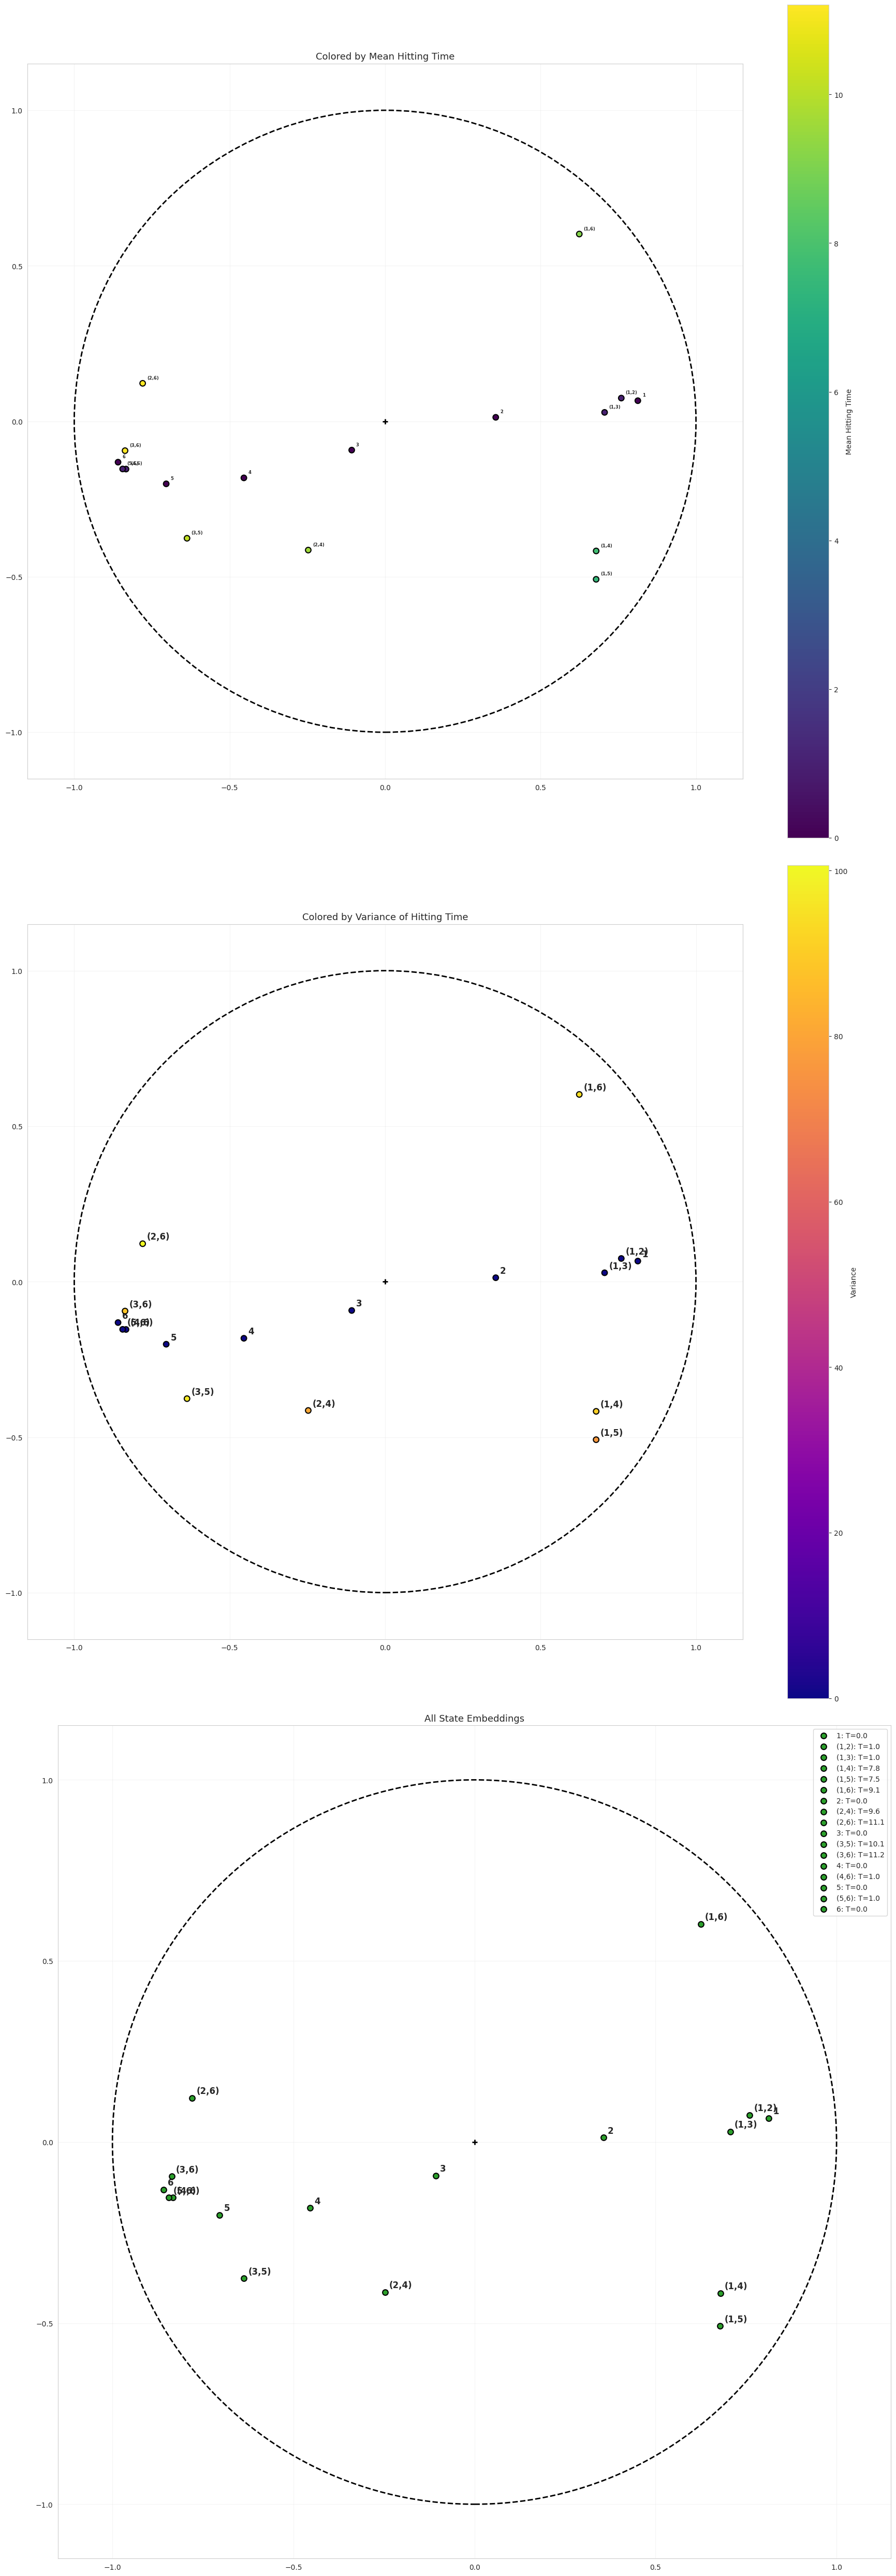

In [51]:
def plot_mdp_embeddings(embeddings, hitting_stats, mdp):
    """
    Visualize embeddings on the Poincare disk, colored by hitting time statistics.
    """
    fig, axes = plt.subplots(3, 1, figsize=(18, 50))

    pairs = sorted(embeddings.keys())
    coords = np.array([embeddings[s] for s in pairs])
    means = np.array([hitting_stats[s]['mean'] for s in pairs])
    vars_ = np.array([hitting_stats[s]['var'] for s in pairs])

    # Plot 1: Colored by mean hitting time
    ax = axes[0]
    plot_poincare_disk(ax, "Colored by Mean Hitting Time")
    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=means, cmap='viridis',
                        s=60, edgecolors='black', linewidth=1.5, zorder=5)
    plt.colorbar(scatter, ax=ax, label='Mean Hitting Time')

    for pair in pairs:
        emb = embeddings[pair]
        label = pair_label(*pair)
        ax.annotate(label, (emb[0], emb[1]), fontsize=6, fontweight='bold',
                   xytext=(6, 6), textcoords='offset points')

    # Plot 2: Colored by variance
    ax = axes[1]
    plot_poincare_disk(ax, "Colored by Variance of Hitting Time")
    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=vars_, cmap='plasma',
                        s=60, edgecolors='black', linewidth=1.5, zorder=5)
    plt.colorbar(scatter, ax=ax, label='Variance')

    for pair in pairs:
        emb = embeddings[pair]
        label = pair_label(*pair)
        ax.annotate(label, (emb[0], emb[1]), fontsize=12, fontweight='bold',
                   xytext=(6, 6), textcoords='offset points')

    # Plot 3: Labeled with all info
    ax = axes[2]
    plot_poincare_disk(ax, "All State Embeddings")

    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))
    for pair in pairs:
        emb = embeddings[pair]
        label = pair_label(*pair)
        ax.scatter([emb[0]], [emb[1]], c=[colors[i]], s=60,
                  edgecolors='black', linewidth=1.5, zorder=5,
                  label=f"{label}: T={hitting_stats[pair]['mean']:.1f}")
        ax.annotate(label, (emb[0], emb[1]), fontsize=12, fontweight='bold',
                   xytext=(6, 6), textcoords='offset points')

    ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.savefig('mdp_embeddings.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_mdp_embeddings(embeddings, hitting_stats, mdp)

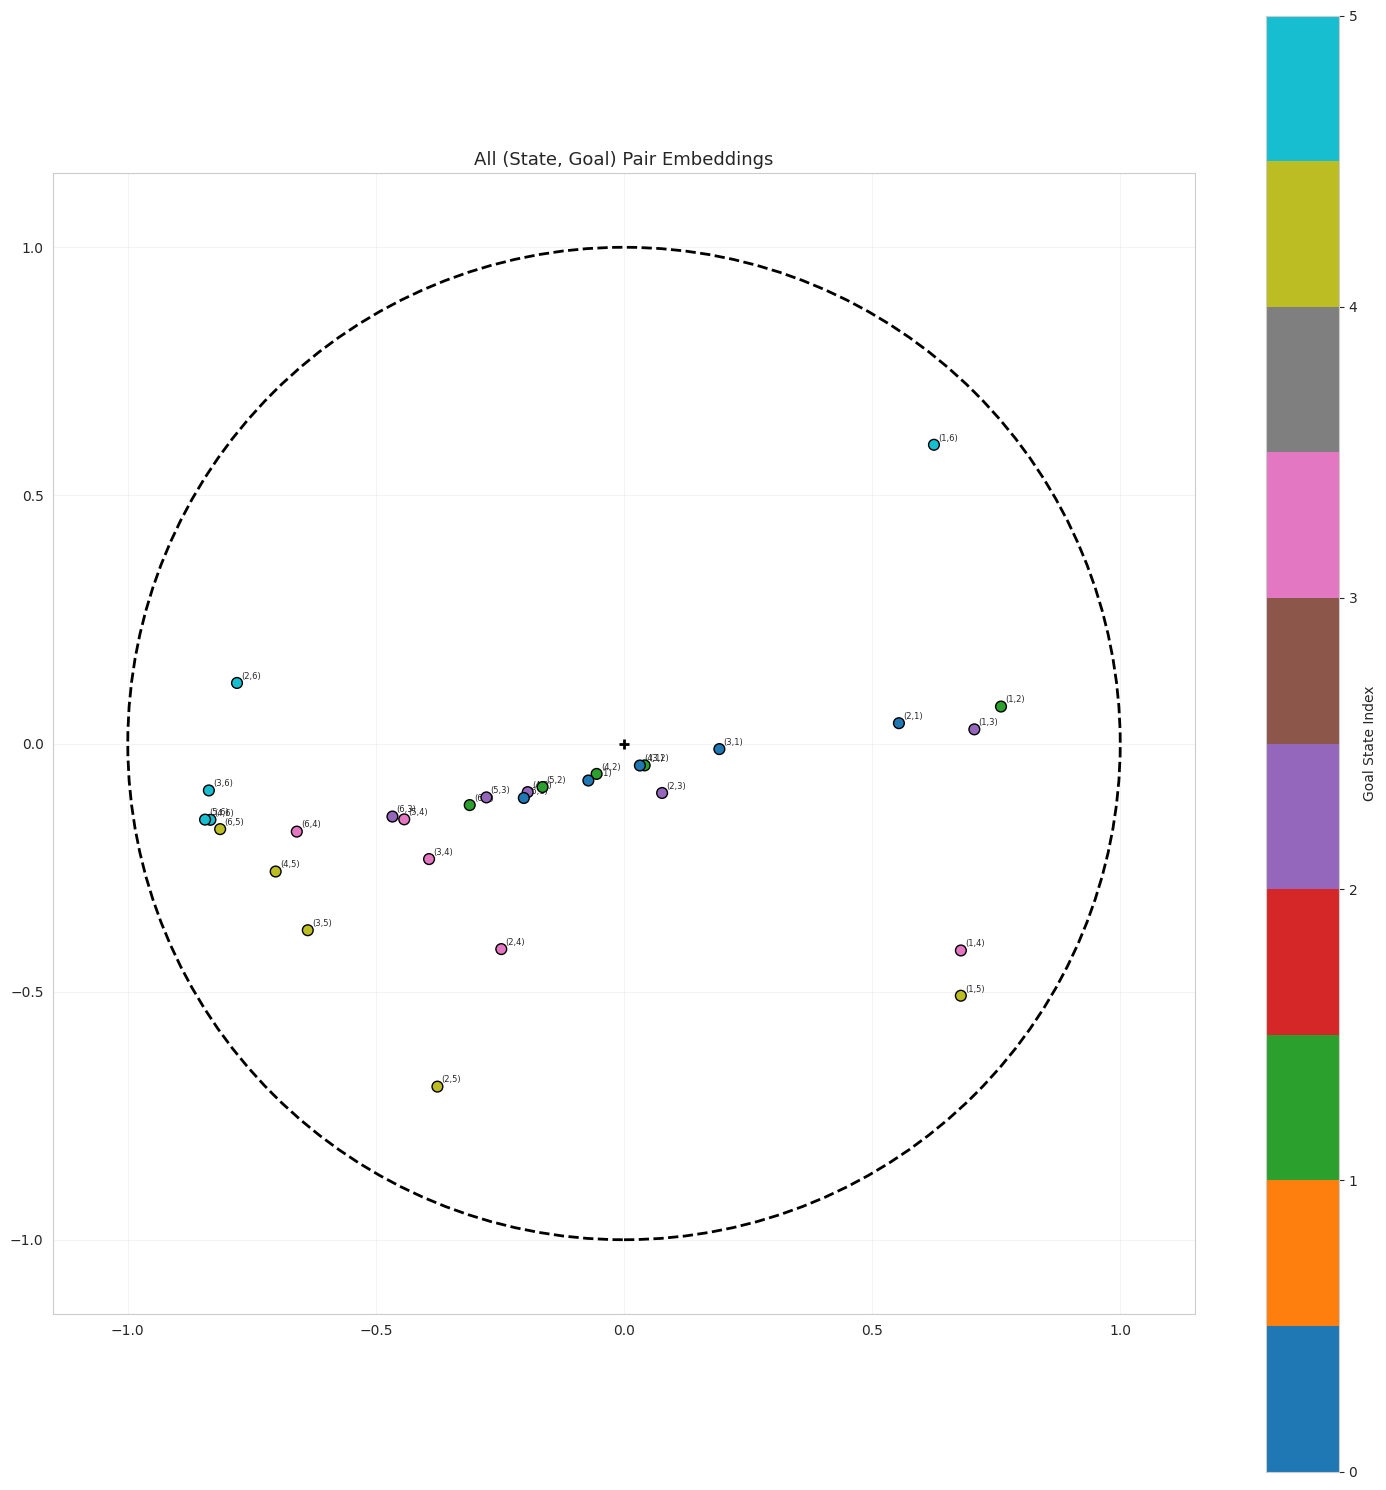

In [54]:
def plot_all_state_pairs(model, mdp):
    """
    Plot embeddings for ALL (state, goal) pairs, not just (state, final_goal).
    """
    model.eval()
    n_states = mdp.n_states

    fig, ax = plt.subplots(figsize=(15, 15))
    plot_poincare_disk(ax, "All (State, Goal) Pair Embeddings")

    all_embeddings = []
    labels = []
    colors = []

    with torch.no_grad():
        for start in range(n_states):
            for goal in range(n_states):
                if start != goal:  # Skip self-loops
                    s_norm = start / (n_states - 1)
                    g_norm = goal / (n_states - 1)

                    x = torch.tensor([[s_norm, g_norm]], dtype=torch.float32).to(device)
                    emb = model(x)

                    if isinstance(emb, ManifoldTensor):
                        emb = emb.tensor

                    emb = emb.squeeze(0).cpu().numpy()
                    all_embeddings.append(emb)
                    labels.append(pair_label(start, goal))
                    colors.append(goal)  # Color by goal state

    all_embeddings = np.array(all_embeddings)
    colors = np.array(colors)

    scatter = ax.scatter(all_embeddings[:, 0], all_embeddings[:, 1],
                        c=colors, cmap='tab10', s=60, edgecolors='black', linewidth=1, zorder=5)

    # Add labels
    for i, label in enumerate(labels):
        ax.annotate(label, all_embeddings[i], fontsize=6,
                   xytext=(3, 3), textcoords='offset points')

    plt.colorbar(scatter, ax=ax, label='Goal State Index')
    plt.tight_layout()
    plt.savefig('all_state_pairs.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_all_state_pairs(model, mdp)

## Goal-Conditioned Behavioral Cloning (GCBC)

We train two policies:
1. **Raw State Policy**: Takes (state, goal) as one-hot encoded inputs
2. **Embedding Policy**: Takes hyperbolic embeddings of (state, goal) pairs

Both are trained via behavioral cloning on the generated trajectories.

In [56]:
# =============================================================================
# GCBC Dataset Creation
# =============================================================================

def create_gcbc_dataset(trajectories, mdp, goal_type="final"):
    """
    Create dataset for goal-conditioned behavioral cloning.

    For each (state, action) in a trajectory, we create a sample:
    - state: current state (0-indexed)
    - goal: final state of trajectory (or random future state)
    - action: action taken (inferred from transition)

    Args:
        trajectories: List of state sequences
        mdp: SimpleMDP instance
        goal_type: "final" (trajectory endpoint) or "random" (random future state)

    Returns:
        states, goals, actions as numpy arrays
    """
    states = []
    goals = []
    actions = []

    for traj in trajectories:
        final_state = traj[-1]  # Usually the goal state

        for t in range(len(traj) - 1):
            state = traj[t]
            next_state = traj[t + 1]

            if state == mdp.goal_state:
                continue  # Skip terminal state

            # Infer action from (state, next_state) transition
            action = infer_action(mdp, state, next_state)
            if action is None:
                continue  # Skip invalid transitions

            if goal_type == "final":
                goal = final_state
            else:  # random future
                future_idx = np.random.randint(t + 1, len(traj))
                goal = traj[future_idx]

            states.append(state)
            goals.append(goal)
            actions.append(action)

    return np.array(states), np.array(goals), np.array(actions)


def infer_action(mdp, state, next_state):
    """
    Infer which action was taken to transition from state to next_state.
    Returns action index or None if transition is impossible.
    """
    for action in range(mdp.n_actions[state]):
        transitions = mdp.get_transitions(state, action)
        for ns, prob in transitions:
            if ns == next_state and prob > 0:
                return action
    return None


# Create GCBC dataset
gcbc_states, gcbc_goals, gcbc_actions = create_gcbc_dataset(trajectories, mdp, goal_type="final")

print(f"GCBC Dataset created:")
print(f"  Total samples: {len(gcbc_states)}")
print(f"  Unique states: {np.unique(gcbc_states)}")
print(f"  Unique goals: {np.unique(gcbc_goals)}")
print(f"  Unique actions: {np.unique(gcbc_actions)}")

# Distribution of actions per state
print("\nAction distribution per state:")
for s in range(mdp.n_states - 1):  # Exclude goal state
    mask = gcbc_states == s
    if mask.sum() > 0:
        action_counts = np.bincount(gcbc_actions[mask], minlength=3)
        print(f"  State {s+1}: {dict(zip(range(len(action_counts)), action_counts))}")

GCBC Dataset created:
  Total samples: 43470
  Unique states: [0 1 2 3 4]
  Unique goals: [5]
  Unique actions: [0 1 2]

Action distribution per state:
  State 1: {0: np.int64(1652), 1: np.int64(1671), 2: np.int64(1677)}
  State 2: {0: np.int64(16843), 1: np.int64(0), 2: np.int64(0)}
  State 3: {0: np.int64(16627), 1: np.int64(0), 2: np.int64(0)}
  State 4: {0: np.int64(2523), 1: np.int64(0), 2: np.int64(0)}
  State 5: {0: np.int64(2477), 1: np.int64(0), 2: np.int64(0)}


In [71]:
# =============================================================================
# GCBC Policy Networks
# =============================================================================

class GCBCPolicyRaw(nn.Module):
    """
    Goal-Conditioned Policy using raw (one-hot) state representations.

    Input: concatenated one-hot encodings of state and goal
    Output: action logits
    """

    def __init__(self, n_states=6, n_actions=3, hidden_dim=64):
        super().__init__()
        self.n_states = n_states
        self.n_actions = n_actions

        # Input: one-hot(state) + one-hot(goal) = 2 * n_states
        input_dim = 2 * n_states

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

    def forward(self, states, goals):
        """
        Args:
            states: tensor of shape (batch,) with state indices
            goals: tensor of shape (batch,) with goal indices
        Returns:
            action logits of shape (batch, n_actions)
        """
        # One-hot encode
        state_onehot = torch.nn.functional.one_hot(states.long(), self.n_states).float()
        goal_onehot = torch.nn.functional.one_hot(goals.long(), self.n_states).float()

        # Concatenate
        x = torch.cat([state_onehot, goal_onehot], dim=-1)

        return self.network(x)

    def get_action(self, state, goal, deterministic=True):
        """Get action for a single (state, goal) pair."""
        self.eval()
        with torch.no_grad():
            s = torch.tensor([state], dtype=torch.long, device=device)
            g = torch.tensor([goal], dtype=torch.long, device=device)
            logits = self.forward(s, g)

            if deterministic:
                return logits.argmax(dim=-1).item()
            else:
                probs = torch.softmax(logits, dim=-1)
                return torch.multinomial(probs, 1).item()

    def get_probabilities(self, state, goal):
        """Get action probabilities for a (state, goal) pair."""
        self.eval()
        with torch.no_grad():
            s = torch.tensor([state], dtype=torch.long, device=device)
            g = torch.tensor([goal], dtype=torch.long, device=device)
            logits = self.forward(s, g)
            probs = torch.softmax(logits, dim=-1)
            return probs


class GCBCPolicyEmbedding(nn.Module):
    """
    Goal-Conditioned Policy using hyperbolic embeddings.

    Input: embedding of (state, goal) pair from trained encoder
    Output: action logits
    """

    def __init__(self, embedding_dim=2, n_actions=3, hidden_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

    def forward(self, embeddings):
        """
        Args:
            embeddings: tensor of shape (batch, embedding_dim)
        Returns:
            action logits of shape (batch, n_actions)
        """
        return self.network(embeddings)

    def get_action(self, embedding, deterministic=True):
        """Get action for a single embedding."""
        self.eval()
        with torch.no_grad():
            emb = torch.tensor(embedding, dtype=torch.float32, device=device).unsqueeze(0)
            logits = self.forward(emb)

            if deterministic:
                return logits.argmax(dim=-1).item()
            else:
                probs = torch.softmax(logits, dim=-1)
                return torch.multinomial(probs, 1).item()

    def get_probabilities(self, embedding):
        """Get action probabilities for an embedding."""
        self.eval()
        with torch.no_grad():
            emb = torch.tensor(embedding, dtype=torch.float32, device=device).unsqueeze(0)
            logits = self.forward(emb)
            probs = torch.softmax(logits, dim=-1)
            return probs


# Test policy networks
raw_policy = GCBCPolicyRaw(n_states=6, n_actions=3).to(device)
emb_policy = GCBCPolicyEmbedding(embedding_dim=2, n_actions=3).to(device)

# Test forward pass
test_states = torch.tensor([0, 1, 2], dtype=torch.long, device=device)
test_goals = torch.tensor([5, 5, 5], dtype=torch.long, device=device)
test_emb = torch.randn(3, 2, device=device)

print("Raw Policy output shape:", raw_policy(test_states, test_goals).shape)
print("Embedding Policy output shape:", emb_policy(test_emb).shape)

Raw Policy output shape: torch.Size([3, 3])
Embedding Policy output shape: torch.Size([3, 3])


Training Raw State Policy
Epoch 5/100, Loss: 0.1266
Epoch 10/100, Loss: 0.1264
Epoch 15/100, Loss: 0.1265
Epoch 20/100, Loss: 0.1264
Epoch 25/100, Loss: 0.1262
Epoch 30/100, Loss: 0.1266
Epoch 35/100, Loss: 0.1262
Epoch 40/100, Loss: 0.1264
Epoch 45/100, Loss: 0.1264
Epoch 50/100, Loss: 0.1263
Epoch 55/100, Loss: 0.1265
Epoch 60/100, Loss: 0.1264
Epoch 65/100, Loss: 0.1264
Epoch 70/100, Loss: 0.1264
Epoch 75/100, Loss: 0.1264
Epoch 80/100, Loss: 0.1263
Epoch 85/100, Loss: 0.1266
Epoch 90/100, Loss: 0.1266
Epoch 95/100, Loss: 0.1263
Epoch 100/100, Loss: 0.1262

Training Embedding Policy
Epoch 5/100, Loss: 0.1264
Epoch 10/100, Loss: 0.1266
Epoch 15/100, Loss: 0.1264
Epoch 20/100, Loss: 0.1264
Epoch 25/100, Loss: 0.1264
Epoch 30/100, Loss: 0.1263
Epoch 35/100, Loss: 0.1265
Epoch 40/100, Loss: 0.1264
Epoch 45/100, Loss: 0.1264
Epoch 50/100, Loss: 0.1263
Epoch 55/100, Loss: 0.1263
Epoch 60/100, Loss: 0.1264
Epoch 65/100, Loss: 0.1262
Epoch 70/100, Loss: 0.1265
Epoch 75/100, Loss: 0.1264
Epo

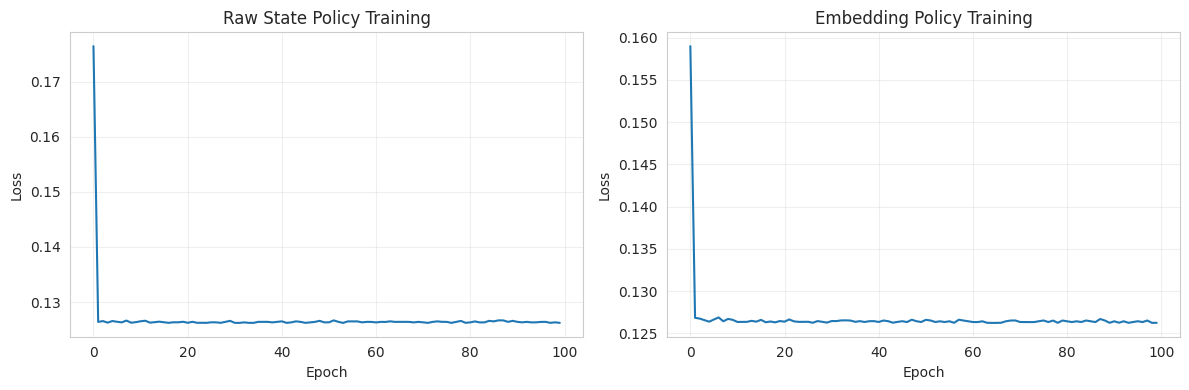

In [59]:
# =============================================================================
# Training Functions
# =============================================================================

def train_raw_policy(policy, states, goals, actions, epochs=100, batch_size=64, lr=0.001):
    """Train the raw state policy via behavioral cloning."""
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Convert to tensors
    states_t = torch.tensor(states, dtype=torch.long, device=device)
    goals_t = torch.tensor(goals, dtype=torch.long, device=device)
    actions_t = torch.tensor(actions, dtype=torch.long, device=device)

    n_samples = len(states)
    losses = []

    policy.train()
    for epoch in range(epochs):
        # Shuffle data
        perm = torch.randperm(n_samples)
        epoch_loss = 0.0
        n_batches = 0

        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            batch_states = states_t[idx]
            batch_goals = goals_t[idx]
            batch_actions = actions_t[idx]

            # Forward pass
            logits = policy(batch_states, batch_goals)
            loss = criterion(logits, batch_actions)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses


def train_embedding_policy(policy, encoder, states, goals, actions, epochs=100, batch_size=64, lr=0.001):
    """Train the embedding policy via behavioral cloning."""
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Get embeddings for all (state, goal) pairs
    encoder.eval()
    n_states = 6

    # Pre-compute embeddings
    with torch.no_grad():
        embeddings = []
        for s, g in zip(states, goals):
            emb = get_embedding(encoder, s, g, n_states)
            embeddings.append(emb)
        embeddings = np.array(embeddings)

    # Convert to tensors
    embeddings_t = torch.tensor(embeddings, dtype=torch.float32, device=device)
    actions_t = torch.tensor(actions, dtype=torch.long, device=device)

    n_samples = len(states)
    losses = []

    policy.train()
    for epoch in range(epochs):
        # Shuffle data
        perm = torch.randperm(n_samples)
        epoch_loss = 0.0
        n_batches = 0

        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            batch_emb = embeddings_t[idx]
            batch_actions = actions_t[idx]

            # Forward pass
            logits = policy(batch_emb)
            loss = criterion(logits, batch_actions)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses


# Train both policies
print("="*60)
print("Training Raw State Policy")
print("="*60)
raw_policy = GCBCPolicyRaw(n_states=6, n_actions=3, hidden_dim=64).to(device)
raw_losses = train_raw_policy(raw_policy, gcbc_states, gcbc_goals, gcbc_actions, epochs=100)

print("\n" + "="*60)
print("Training Embedding Policy")
print("="*60)
emb_policy = GCBCPolicyEmbedding(embedding_dim=2, n_actions=3, hidden_dim=64).to(device)
emb_losses = train_embedding_policy(emb_policy, model, gcbc_states, gcbc_goals, gcbc_actions, epochs=100)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(raw_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Raw State Policy Training')
axes[0].grid(True, alpha=0.3)

axes[1].plot(emb_losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Embedding Policy Training')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
start_state = 0
goal_state = 5
embedding = get_embedding(model, start_state, goal_state, mdp.n_states)

probabilities_raw = raw_policy.get_probabilities(start_state, goal_state)[0]
probabilities_emb = emb_policy.get_probabilities(embedding)[0]

for i in range(3):
    transitions = mdp.get_transitions(start_state, i)
    print(f"Action {i} has transitions {transitions}")
    print(f"Its raw policy prob: {probabilities_raw[i]:.3f}")
    print(f"Its emb policy prob: {probabilities_emb[i]:.3f}")
    print(50*"=")


Action 0 has transitions [(3, 0.5), (4, 0.5)]
Its raw policy prob: 0.331
Its emb policy prob: 0.339
Action 1 has transitions [(1, 1.0)]
Its raw policy prob: 0.370
Its emb policy prob: 0.328
Action 2 has transitions [(2, 1.0)]
Its raw policy prob: 0.298
Its emb policy prob: 0.333


## Policy Evaluati
Evaluate both policies (raw and embedding-based) in two modes:
1. **Deterministic**: Always take argmax action
2. **Stochastic**: Sample from action distribution

Metrics: Average steps to reach goal from start state

In [60]:
# =============================================================================
# Policy Evaluation
# =============================================================================

def evaluate_raw_policy(policy, mdp, n_episodes=1000, max_steps=1000, deterministic=True):
    """
    Evaluate raw state policy.

    Args:
        policy: GCBCPolicyRaw
        mdp: SimpleMDP
        n_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        deterministic: If True, use argmax; else sample from distribution

    Returns:
        dict with mean_steps, std_steps, success_rate
    """
    policy.eval()
    steps_list = []
    successes = 0

    for _ in range(n_episodes):
        state = mdp.start_state
        goal = mdp.goal_state
        steps = 0

        while state != goal and steps < max_steps:
            # Get action from policy
            action = policy.get_action(state, goal, deterministic=deterministic)

            # Clip action to valid range for this state
            action = min(action, mdp.n_actions[state] - 1)

            # Take step in environment
            state = mdp.step(state, action)
            steps += 1

        if state == goal:
            successes += 1
            steps_list.append(steps)
        else:
            steps_list.append(max_steps)  # Failure case

    return {
        'mean_steps': np.mean(steps_list),
        'std_steps': np.std(steps_list),
        'success_rate': successes / n_episodes,
        'steps_list': steps_list
    }


def evaluate_embedding_policy(policy, encoder, mdp, n_episodes=1000, max_steps=1000, deterministic=True):
    """
    Evaluate embedding policy.

    Args:
        policy: GCBCPolicyEmbedding
        encoder: HyperbolicIntervalEncoder
        mdp: SimpleMDP
        n_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        deterministic: If True, use argmax; else sample from distribution

    Returns:
        dict with mean_steps, std_steps, success_rate
    """
    policy.eval()
    encoder.eval()
    steps_list = []
    successes = 0

    for _ in range(n_episodes):
        state = mdp.start_state
        goal = mdp.goal_state
        steps = 0

        while state != goal and steps < max_steps:
            # Get embedding
            emb = get_embedding(encoder, state, goal, mdp.n_states)

            # Get action from policy
            action = policy.get_action(emb, deterministic=deterministic)

            # Clip action to valid range for this state
            action = min(action, mdp.n_actions[state] - 1)

            # Take step in environment
            state = mdp.step(state, action)
            steps += 1

        if state == goal:
            successes += 1
            steps_list.append(steps)
        else:
            steps_list.append(max_steps)

    return {
        'mean_steps': np.mean(steps_list),
        'std_steps': np.std(steps_list),
        'success_rate': successes / n_episodes,
        'steps_list': steps_list
    }


def evaluate_random_policy(mdp, n_episodes=1000, max_steps=1000):
    """Evaluate random policy (baseline)."""
    steps_list = []
    successes = 0

    for _ in range(n_episodes):
        state = mdp.start_state
        steps = 0

        while state != mdp.goal_state and steps < max_steps:
            state = mdp.step(state, action=None)  # Random action
            steps += 1

        if state == mdp.goal_state:
            successes += 1
            steps_list.append(steps)
        else:
            steps_list.append(max_steps)

    return {
        'mean_steps': np.mean(steps_list),
        'std_steps': np.std(steps_list),
        'success_rate': successes / n_episodes,
        'steps_list': steps_list
    }


# Evaluate all policies
print("="*70)
print("POLICY EVALUATION")
print("="*70)

n_eval_episodes = 5000

# Random baseline
print("\nRandom Policy (Baseline):")
random_results = evaluate_random_policy(mdp, n_episodes=n_eval_episodes)
print(f"  Mean steps: {random_results['mean_steps']:.2f} ± {random_results['std_steps']:.2f}")
print(f"  Success rate: {random_results['success_rate']*100:.1f}%")

# Raw policy - deterministic
print("\nRaw State Policy (Deterministic):")
raw_det_results = evaluate_raw_policy(raw_policy, mdp, n_episodes=n_eval_episodes, deterministic=True)
print(f"  Mean steps: {raw_det_results['mean_steps']:.2f} ± {raw_det_results['std_steps']:.2f}")
print(f"  Success rate: {raw_det_results['success_rate']*100:.1f}%")

# Raw policy - stochastic
print("\nRaw State Policy (Stochastic):")
raw_stoch_results = evaluate_raw_policy(raw_policy, mdp, n_episodes=n_eval_episodes, deterministic=False)
print(f"  Mean steps: {raw_stoch_results['mean_steps']:.2f} ± {raw_stoch_results['std_steps']:.2f}")
print(f"  Success rate: {raw_stoch_results['success_rate']*100:.1f}%")

# Embedding policy - deterministic
print("\nEmbedding Policy (Deterministic):")
emb_det_results = evaluate_embedding_policy(emb_policy, model, mdp, n_episodes=n_eval_episodes, deterministic=True)
print(f"  Mean steps: {emb_det_results['mean_steps']:.2f} ± {emb_det_results['std_steps']:.2f}")
print(f"  Success rate: {emb_det_results['success_rate']*100:.1f}%")

# Embedding policy - stochastic
print("\nEmbedding Policy (Stochastic):")
emb_stoch_results = evaluate_embedding_policy(emb_policy, model, mdp, n_episodes=n_eval_episodes, deterministic=False)
print(f"  Mean steps: {emb_stoch_results['mean_steps']:.2f} ± {emb_stoch_results['std_steps']:.2f}")
print(f"  Success rate: {emb_stoch_results['success_rate']*100:.1f}%")

POLICY EVALUATION

Random Policy (Baseline):
  Mean steps: 8.76 ± 9.15
  Success rate: 100.0%

Raw State Policy (Deterministic):
  Mean steps: 12.10 ± 9.68
  Success rate: 100.0%

Raw State Policy (Stochastic):
  Mean steps: 8.68 ± 8.99
  Success rate: 100.0%

Embedding Policy (Deterministic):
  Mean steps: 11.88 ± 9.56
  Success rate: 100.0%

Embedding Policy (Stochastic):
  Mean steps: 8.84 ± 9.15
  Success rate: 100.0%


In [70]:
# Summary table
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)
print(f"{'Policy':<25} {'Mean Steps':>12} {'Std':>10} {'Success':>12}")
print("-"*70)
print(f"{'Random (Baseline)':<25} {random_results['mean_steps']:>12.2f} {random_results['std_steps']:>10.2f} {random_results['success_rate']*100:>11.1f}%")
print(f"{'Raw State (Det)':<25} {raw_det_results['mean_steps']:>12.2f} {raw_det_results['std_steps']:>10.2f} {raw_det_results['success_rate']*100:>11.1f}%")
print(f"{'Raw State (Stoch)':<25} {raw_stoch_results['mean_steps']:>12.2f} {raw_stoch_results['std_steps']:>10.2f} {raw_stoch_results['success_rate']*100:>11.1f}%")
print(f"{'Embedding (Det)':<25} {emb_det_results['mean_steps']:>12.2f} {emb_det_results['std_steps']:>10.2f} {emb_det_results['success_rate']*100:>11.1f}%")
print(f"{'Embedding (Stoch)':<25} {emb_stoch_results['mean_steps']:>12.2f} {emb_stoch_results['std_steps']:>10.2f} {emb_stoch_results['success_rate']*100:>11.1f}%")
print("="*70)


EVALUATION SUMMARY
Policy                      Mean Steps        Std      Success
----------------------------------------------------------------------
Random (Baseline)                 8.76       9.15       100.0%
Raw State (Det)                  12.10       9.68       100.0%
Raw State (Stoch)                 8.68       8.99       100.0%
Embedding (Det)                  11.88       9.56       100.0%
Embedding (Stoch)                 8.84       9.15       100.0%


## Hyperbolic Planning Mechanism

The planning mechanism works as follows:

1. **Compute embedding** φ(s₁, s₂) for the (start, goal) pair
2. **Find subgoal**: Find the lowest-norm atomic embedding φ(s', s') that lies along the radial line through φ(s₁, s₂)
3. **Decode state**: Map the embedding back to a concrete state s'
4. **Recurse**: Apply the algorithm recursively on (s₁, s') and (s', s₂)
5. **Display plan**: Show the resulting hierarchical plan

The intuition is that atomic states (s, s) with low norm represent "waypoints" that are easy to reach (low variance in hitting time), and the radial line represents the "direction" of the plan.

HYPERBOLIC PLANNING

Plan from (1,6):
  Sequence: 1 -> 2 -> 1 -> 3 -> 4 -> 6
  States: 1 -> 2 -> 1 -> 3 -> 4 -> 6


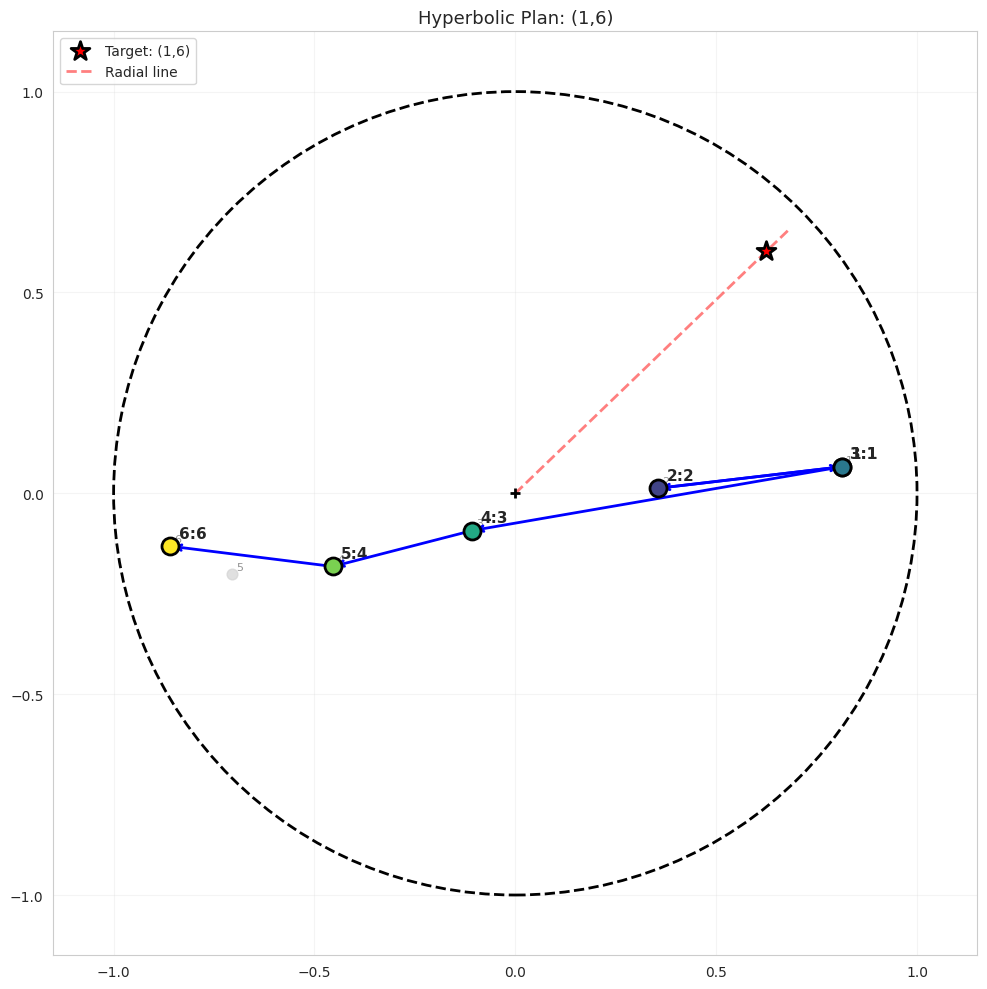

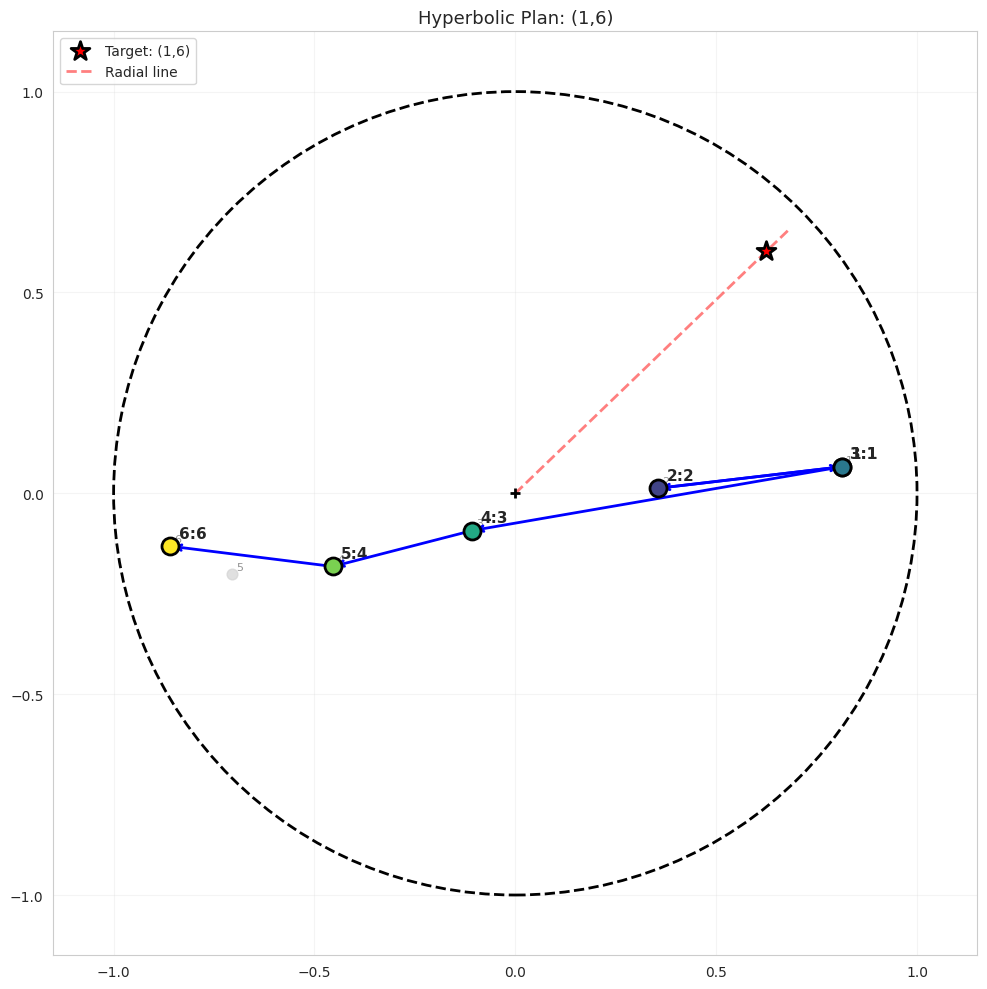

In [68]:
# =============================================================================
# Hyperbolic Planning
# =============================================================================

def get_atomic_embeddings(model, mdp):
    """
    Get embeddings for all atomic (state, state) pairs.

    Returns:
        dict: {state: embedding_array}
    """
    model.eval()
    atomic_emb = {}

    with torch.no_grad():
        for s in range(mdp.n_states):
            emb = get_embedding(model, s, s, mdp.n_states)
            atomic_emb[s] = emb

    return atomic_emb


def angular_distance(v1, v2):
    """
    Compute angular distance between two vectors.
    Returns angle in radians (0 to π).
    """
    # Normalize vectors
    v1_norm = v1 / (np.linalg.norm(v1) + 1e-10)
    v2_norm = v2 / (np.linalg.norm(v2) + 1e-10)

    # Dot product gives cosine of angle
    cos_angle = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)

    return np.arccos(cos_angle)


def find_subgoal_on_radial_line(target_emb, atomic_embeddings, start_state, goal_state,
                                 angle_threshold=np.pi/4, exclude_states=None):
    """
    Find the best subgoal along the radial line from origin through target_emb.

    The subgoal should be:
    - An atomic state (s', s') that is different from start and goal
    - Close to the radial line (low angular distance)
    - Has the lowest hyperbolic norm among valid candidates

    Args:
        target_emb: Embedding of (start, goal) pair
        atomic_embeddings: Dict of {state: embedding} for atomic states
        start_state: Start state (to exclude)
        goal_state: Goal state (to exclude)
        angle_threshold: Maximum angular deviation from radial line
        exclude_states: Additional states to exclude

    Returns:
        best_state: The best subgoal state, or None if no valid candidate
        best_emb: Embedding of the subgoal
    """
    if exclude_states is None:
        exclude_states = set()

    exclude_states = set(exclude_states) | {start_state, goal_state}

    best_state = None
    best_norm = float('inf')
    best_emb = None

    target_angle = np.arctan2(target_emb[1], target_emb[0])

    for state, emb in atomic_embeddings.items():
        if state in exclude_states:
            continue

        # Check angular distance from radial line
        angle_dist = angular_distance(target_emb, emb)

        if angle_dist <= angle_threshold:
            norm = hyperbolic_norm(emb)
            if norm < best_norm:
                best_norm = norm
                best_state = state
                best_emb = emb

    return best_state, best_emb


def hyperbolic_plan(model, mdp, start_state, goal_state, max_depth=3, angle_threshold=np.pi/4):
    """
    Generate a hierarchical plan using hyperbolic embeddings.

    The algorithm:
    1. Get embedding φ(start, goal)
    2. Find lowest-norm atomic embedding φ(s', s') along radial line
    3. If found, recursively plan (start, s') and (s', goal)
    4. Return the hierarchical plan

    Args:
        model: Trained hyperbolic encoder
        mdp: MDP instance
        start_state: Starting state
        goal_state: Goal state
        max_depth: Maximum recursion depth
        angle_threshold: Angular tolerance for radial line matching

    Returns:
        plan: List of subgoals (hierarchical decomposition)
    """
    model.eval()
    neighbors = mdp.get_all_neighbors()
    # Get atomic embeddings
    atomic_emb = get_atomic_embeddings(model, mdp)

    def plan_recursive(s1, s2, depth, visited):
        """Recursive planning helper."""
        if depth >= max_depth or (s1,s2) in neighbors:
            return [s1, s2]

        # Get embedding for this pair
        pair_emb = get_embedding(model, s1, s2, mdp.n_states)

        # Find subgoal on radial line
        subgoal, subgoal_emb = find_subgoal_on_radial_line(
            pair_emb, atomic_emb, s1, s2,
            angle_threshold=angle_threshold,
            exclude_states=visited
        )

        if subgoal is None or subgoal in visited:
            # No valid subgoal found
            return [s1, s2]

        # Recurse on both halves
        visited_new = visited | {subgoal}
        left_plan = plan_recursive(s1, subgoal, depth + 1, visited_new)
        right_plan = plan_recursive(subgoal, s2, depth + 1, visited_new)

        # Combine plans (avoiding duplicate subgoal)
        if right_plan and right_plan[0] == subgoal:
            return left_plan + right_plan[1:]
        return left_plan + right_plan

    plan = plan_recursive(start_state, goal_state, 0, set())
    return plan


def visualize_plan(model, mdp, start_state, goal_state, plan):
    """
    Visualize the planning process on the Poincare disk.
    """
    model.eval()

    fig, ax = plt.subplots(figsize=(10, 10))
    plot_poincare_disk(ax, f"Hyperbolic Plan: {pair_label(start_state, goal_state)}")

    # Get atomic embeddings
    atomic_emb = get_atomic_embeddings(model, mdp)

    # Plot all atomic embeddings in light gray
    for s, emb in atomic_emb.items():
        ax.scatter([emb[0]], [emb[1]], c='lightgray', s=60, zorder=2, alpha=0.7)
        ax.annotate(pair_label(s, s), (emb[0], emb[1]), fontsize=8, alpha=0.5,
                   xytext=(3, 3), textcoords='offset points')

    # Plot the main (start, goal) embedding
    main_emb = get_embedding(model, start_state, goal_state, mdp.n_states)
    ax.scatter([main_emb[0]], [main_emb[1]], c='red', s=200, marker='*',
              edgecolors='black', linewidth=2, zorder=10,
              label=f'Target: {pair_label(start_state, goal_state)}')

    # Draw radial line from origin through target
    direction = main_emb / (np.linalg.norm(main_emb) + 1e-10)
    line_end = direction * 0.95  # Almost to boundary
    ax.plot([0, line_end[0]], [0, line_end[1]], 'r--', linewidth=2, alpha=0.5, label='Radial line')

    # Highlight plan states
    colors = plt.cm.viridis(np.linspace(0, 1, len(plan)))
    for i, state in enumerate(plan):
        emb = atomic_emb[state]
        ax.scatter([emb[0]], [emb[1]], c=[colors[i]], s=150,
                  edgecolors='black', linewidth=2, zorder=5)
        ax.annotate(f"{i+1}:{pair_label(state, state)}", (emb[0], emb[1]),
                   fontsize=11, fontweight='bold',
                   xytext=(6, 6), textcoords='offset points')

    # Draw arrows between plan states
    for i in range(len(plan) - 1):
        emb1 = atomic_emb[plan[i]]
        emb2 = atomic_emb[plan[i + 1]]
        ax.annotate('', xy=emb2, xytext=emb1,
                   arrowprops=dict(arrowstyle='->', color='blue', lw=2))

    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig('hyperbolic_plan.png', dpi=150, bbox_inches='tight')
    plt.show()

    return fig


# Generate and display plan from state 1 to state 6
print("="*70)
print("HYPERBOLIC PLANNING")
print("="*70)

start = mdp.start_state  # State 1 (index 0)
goal = mdp.goal_state    # State 6 (index 5)

plan = hyperbolic_plan(model, mdp, start, goal, max_depth=3, angle_threshold=np.pi/3)

print(f"\nPlan from {pair_label(start, goal)}:")
print(f"  Sequence: {' -> '.join([pair_label(s, s) for s in plan])}")
print(f"  States: {' -> '.join([str(s+1) for s in plan])}")

# Visualize
visualize_plan(model, mdp, start, goal, plan)

ATOMIC EMBEDDINGS φ(s, s)
State      Embedding                 Norm         Angle (deg) 
----------------------------------------------------------------------
1          (+0.8129, +0.0661)      2.2871       +4.7
2          (+0.3559, +0.0126)      0.7448       +2.0
3          (-0.1074, -0.0928)      0.2858       -139.2
4          (-0.4543, -0.1821)      1.0707       -158.2
5          (-0.7042, -0.2012)      1.8677       -164.1
6          (-0.8591, -0.1316)      2.6590       -171.3


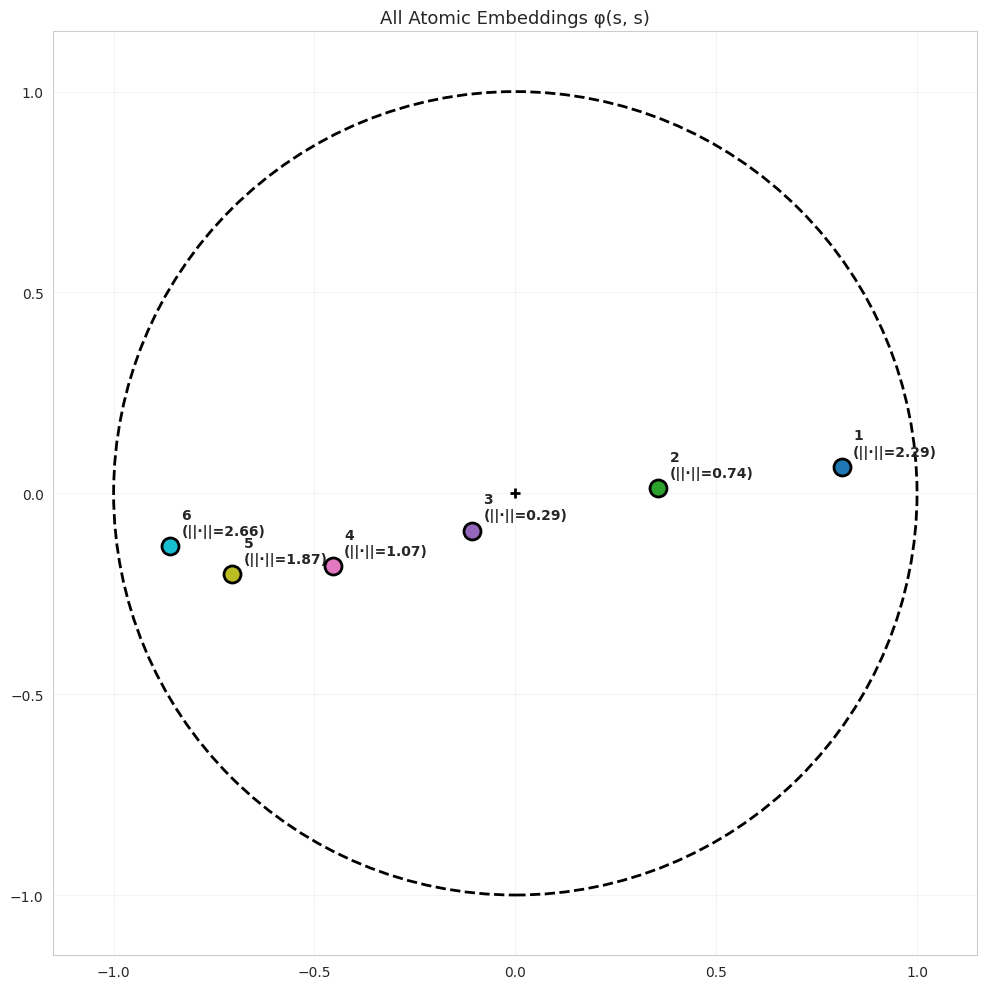


PLANS FROM ALL STATES TO GOAL
  (1,6): 1 -> 2 -> 4 -> 6
  (2,6): 2 -> 4 -> 6
  (3,6): 3 -> 5 -> 3 -> 4 -> 6
  (4,6): 4 -> 6
  (5,6): 5 -> 6


In [69]:
# =============================================================================
# Analysis of Atomic Embeddings and Plans
# =============================================================================

# Get and display atomic embeddings
print("="*70)
print("ATOMIC EMBEDDINGS φ(s, s)")
print("="*70)
print(f"{'State':<10} {'Embedding':<25} {'Norm':<12} {'Angle (deg)':<12}")
print("-"*70)

atomic_emb = get_atomic_embeddings(model, mdp)
for s in range(mdp.n_states):
    emb = atomic_emb[s]
    norm = hyperbolic_norm(emb)
    angle = np.degrees(np.arctan2(emb[1], emb[0]))
    print(f"{pair_label(s, s):<10} ({emb[0]:+.4f}, {emb[1]:+.4f}){'':>5} {norm:<12.4f} {angle:+.1f}")

# Plot all atomic embeddings
fig, ax = plt.subplots(figsize=(10, 10))
plot_poincare_disk(ax, "All Atomic Embeddings φ(s, s)")

colors = plt.cm.tab10(np.linspace(0, 1, mdp.n_states))
for s in range(mdp.n_states):
    emb = atomic_emb[s]
    norm = hyperbolic_norm(emb)
    ax.scatter([emb[0]], [emb[1]], c=[colors[s]], s=150,
              edgecolors='black', linewidth=2, zorder=5)
    ax.annotate(f"{pair_label(s, s)}\n(||·||={norm:.2f})", (emb[0], emb[1]),
               fontsize=10, fontweight='bold',
               xytext=(8, 8), textcoords='offset points')

plt.tight_layout()
plt.savefig('atomic_embeddings.png', dpi=150, bbox_inches='tight')
plt.show()

# Generate plans from all non-goal states
print("\n" + "="*70)
print("PLANS FROM ALL STATES TO GOAL")
print("="*70)

for start_s in range(mdp.n_states):
    if start_s != mdp.goal_state:
        plan = hyperbolic_plan(model, mdp, start_s, mdp.goal_state, max_depth=3)
        print(f"  {pair_label(start_s, mdp.goal_state)}: {' -> '.join([str(s+1) for s in plan])}")